# Final Year Project - Intelligent Health Monitoring System
#### by: Koo Chia Meng, A0165275Y

### DATA EXPLORATION

### Comparison of Data gotten from Subjects (PERSON 1 and 2)

The following will be done in this Notebook:
1. Comparing the data of Person 1 and 2 gotten from the previous stages.
    - Resting Heart Rate per day
    - Total Calories per day
    - Duration in Heart Rate Zones per day
    - Sleep efficiency, Duration and stages per day
    - Calculated Heart Rate Variability per day
    - Number of steps per day

### Importing both person data

In [2]:
#Import relevant Dependencies

import datetime
import time
import pandas as pd # Pandas Version 1.0.5
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats as sps
import sklearn.linear_model as lm
import seaborn as sns # use for visualising
import os

In [3]:
%run FYP_SUBJECTS_CLASS.ipynb # line needed to reuse the SUBJECT class created for OOP

### Loading Subjects from PICKLE

In [4]:
current_directory = os.getcwd()
folder = "PERSON1" # CHANGE HERE
file = "PERSON1_DATA_31JUL.pickle" # CHANGE HERE
f_path = os.path.join(current_directory,folder,file)
                      
with open(f_path,'rb') as f:
    PERSON1 = pickle.load(file=f)

In [5]:
PERSON1.profile

{'age': 28, 'gender': 'MALE', 'height': 170.0, 'weight': 75.0}

In [6]:
current_directory = os.getcwd()
folder = "PERSON2" # CHANGE HERE
file = "PERSON2_DATA_31JUL.pickle" # CHANGE HERE
f_path = os.path.join(current_directory,folder,file)
                      
with open(f_path,'rb') as f:
    PERSON2 = pickle.load(file=f)

In [7]:
PERSON2.profile

{'age': 27, 'gender': 'MALE', 'height': 176.0, 'weight': 65.0}

### Loading Previously Processed DFs from PICKLE

In [8]:
current_directory = os.getcwd()
folder = os.path.join("PERSON1","31JUL") # CHANGE HERE
folder_path = os.path.join(current_directory,folder)

# LOAD FROM PICKLE:

unpickle = {}
unpickle_list = [
                # Daily Resting Heart Rate DF:
                'df_resting_hr',

                # Daily Heart Rate Zones (HR Activities) DF:
                'df_hr_calories',

                # Intra-day Heart Rate DF:
                'df_intraday_hr',

                # Sleep Durations DF
                'df_sleep_durations',

                # Detailed intra Sleep Stages DF
                'df_intra_sleep_stage',

                # Daily Step activities DF:
                'df_activity_steps',
    
                # Derived HRV Stats DFs:
                'df_hrv_stats_full_day',
                'df_hrv_stats_AM',
                'df_hrv_stats_PM'
]

for i in unpickle_list:
    file = os.path.join(folder_path, str(i) + '.pickle')
    with open(file,'rb') as f:
        unpickle[i] = pickle.load(file=f)

PERSON1.df_resting_hr = unpickle['df_resting_hr']
PERSON1.df_hr_calories = unpickle['df_hr_calories']
PERSON1.df_intraday_hr = unpickle['df_intraday_hr']
PERSON1.df_sleep_durations = unpickle['df_sleep_durations']
PERSON1.df_intra_sleep_stage = unpickle['df_intra_sleep_stage']
PERSON1.df_activity_steps = unpickle['df_activity_steps']
PERSON1.df_hrv_stats_full_day = unpickle['df_hrv_stats_full_day']
PERSON1.df_hrv_stats_AM = unpickle['df_hrv_stats_AM']
PERSON1.df_hrv_stats_PM = unpickle['df_hrv_stats_PM']


In [9]:
current_directory = os.getcwd()
folder = os.path.join("PERSON2","31JUL") # CHANGE HERE
folder_path = os.path.join(current_directory,folder)

# LOAD FROM PICKLE:

unpickle = {}
unpickle_list = [
                # Daily Resting Heart Rate DF:
                'df_resting_hr',

                # Daily Heart Rate Zones (HR Activities) DF:
                'df_hr_calories',

                # Intra-day Heart Rate DF:
                'df_intraday_hr',

                # Sleep Durations DF
                'df_sleep_durations',

                # Detailed intra Sleep Stages DF
                'df_intra_sleep_stage',

                # Daily Step activities DF:
                'df_activity_steps',
    
                # Derived HRV Stats DFs:
                'df_hrv_stats_full_day',
                'df_hrv_stats_AM',
                'df_hrv_stats_PM'
]

for i in unpickle_list:
    file = os.path.join(folder_path, str(i) + '.pickle')
    with open(file,'rb') as f:
        unpickle[i] = pickle.load(file=f)

PERSON2.df_resting_hr = unpickle['df_resting_hr']
PERSON2.df_hr_calories = unpickle['df_hr_calories']
PERSON2.df_intraday_hr = unpickle['df_intraday_hr']
PERSON2.df_sleep_durations = unpickle['df_sleep_durations']
PERSON2.df_intra_sleep_stage = unpickle['df_intra_sleep_stage']
PERSON2.df_activity_steps = unpickle['df_activity_steps']
PERSON2.df_hrv_stats_full_day = unpickle['df_hrv_stats_full_day']
PERSON2.df_hrv_stats_AM = unpickle['df_hrv_stats_AM']
PERSON2.df_hrv_stats_PM = unpickle['df_hrv_stats_PM']

In [10]:
PERSON_LIST = [PERSON1,PERSON2] # Declare a list of person to create

### EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTION
This is use together with scatter plotting to view the cumulative distribution function

In [10]:
# Referenced from DATACAMP.com:

def ecdf(data):
    """FUNCTION TO GENERATE ECDF, REUTRNS X, Y"""
    
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF, actual value: x
    x = np.sort(data)

    # y-data for the ECDF, Cumulative Probability: y
    y = np.arange(1, n+1) / n

    return x, y

### BOOSTRAP REPLICATES FUNCTION
This is to generate more samples to find more a better estimate of a statistical value (like mean) base on existing datasets.
SD of the bootstrap sample will give the Standard Error, (MEAN +- SD). Confidence Interval, (CI) for the statistical value can also be obtained.

In [11]:
# Referenced from DATACAMP.com:

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates

### PERMUTATION REPLICATES FUNCTION

This is used for explore relations and prove NULL HYPOTHESIS. if 2 data set is related or the same, their values will be as extreme, thus p-value will be high. (no relationship = very small p-values)

In [12]:
# Referenced from DATACAMP.com:

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [13]:
# Referenced from DATACAMP.com:

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)

    return perm_replicates

### Visualising the ECDF for current datasets
#### STEP ACTIVITY:

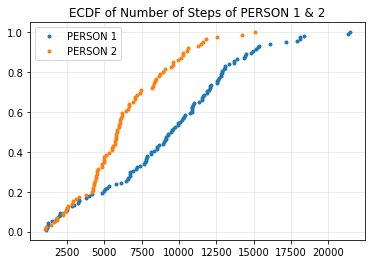

In [14]:
# df_step_combined = pd.concat([PERSON1.df_activity_steps,PERSON2.df_activity_steps])

# PERSON 1:
x,y = ecdf(PERSON1.df_activity_steps.step_count)
plt.plot(x,y,'.',label='PERSON 1')

# PERSON 2:
x,y = ecdf(PERSON2.df_activity_steps.step_count)
plt.plot(x,y,'.',label='PERSON 2')

plt.title('ECDF of Number of Steps of PERSON 1 & 2')
plt.grid(':',alpha=0.3)
plt.legend()
plt.show()

#### RHR:

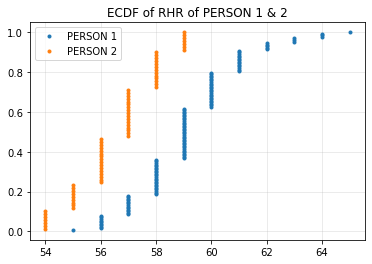

In [15]:
# PERSON 1:
x,y = ecdf(PERSON1.df_resting_hr.restingHeartRate)
plt.plot(x,y,'.',label='PERSON 1')

# PERSON 2:
x,y = ecdf(PERSON2.df_resting_hr.restingHeartRate)
plt.plot(x,y,'.',label='PERSON 2')

plt.title('ECDF of RHR of PERSON 1 & 2')
plt.grid(':',alpha=0.3)
plt.legend()
plt.show()

### CALORIES & HEART RATE ZONE DURATIONS:

In [16]:
PERSON1.df_hr_calories.columns

Index(['Total_caloriesOut', 'minutes_Regular', 'minutes_Fatburn',
       'minutes_Cardio', 'minutes_Peak', 'Total_minutes'],
      dtype='object')

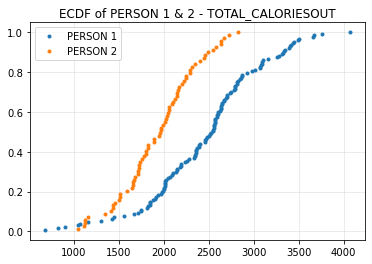

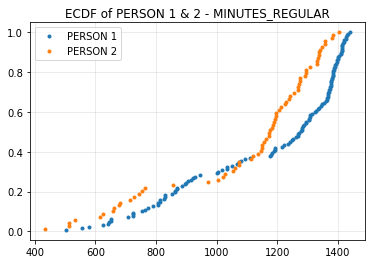

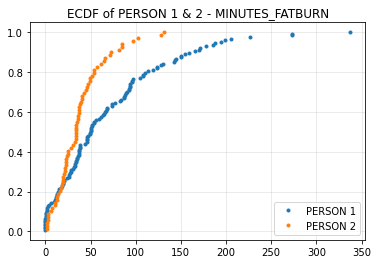

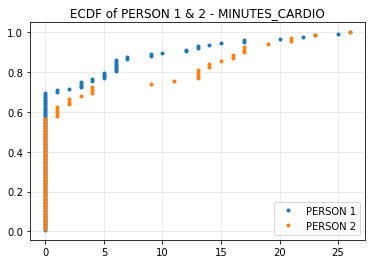

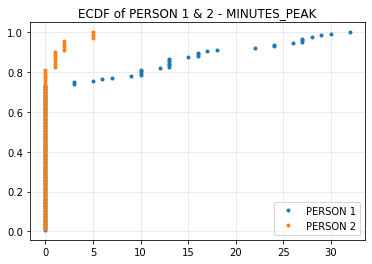

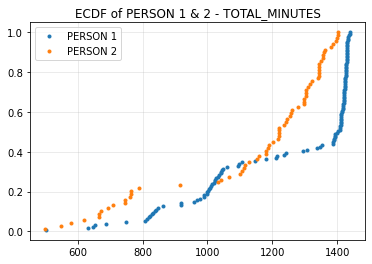

In [17]:
cols = PERSON1.df_hr_calories.columns

for col in cols:
    # PERSON 1:
    plt.figure()
    x,y = ecdf(PERSON1.df_hr_calories[col])
    plt.plot(x,y,'.',label='PERSON 1')

    # PERSON 2:
    x,y = ecdf(PERSON2.df_hr_calories[col])
    plt.plot(x,y,'.',label='PERSON 2')

    plt.title('ECDF of PERSON 1 & 2 - ' + col.upper())
    plt.grid(':',alpha=0.3)
    plt.legend()
plt.show()

### SLEEP DATA:

In [18]:
PERSON1.df_sleep_durations.columns

Index(['duration', 'minutesAsleep', 'efficiency', 'startTime', 'endTime',
       'DeepSleep_Count', 'DeepSleep_Minutes', 'LightSleep_Count',
       'LightSleep_Minutes', 'RemSleep_Count', 'RemSleep_Minutes',
       'Wake_Count', 'Wake_Minutes'],
      dtype='object')

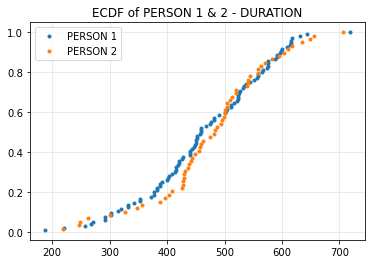

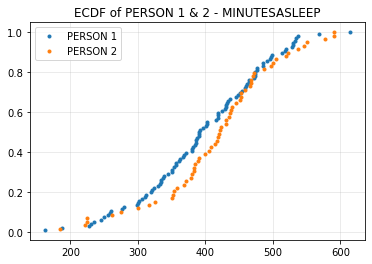

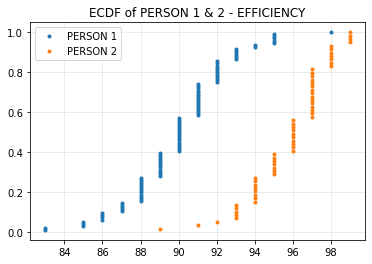

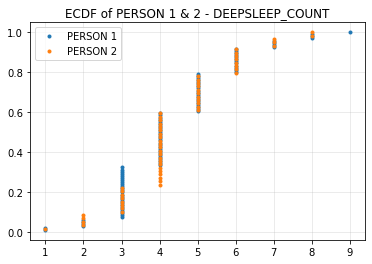

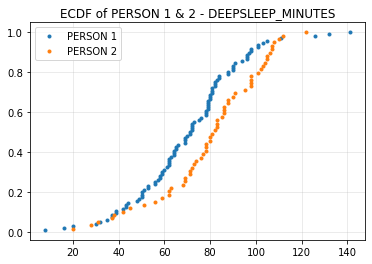

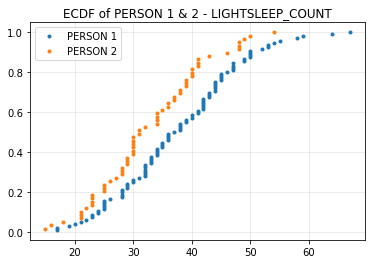

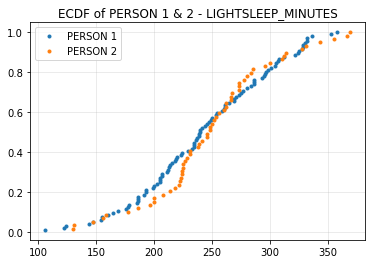

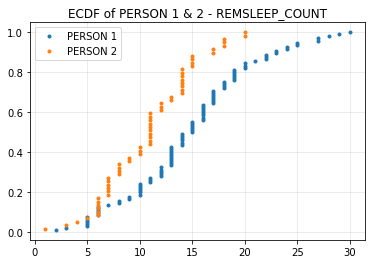

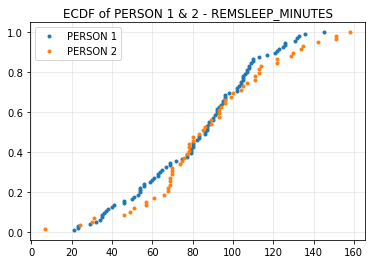

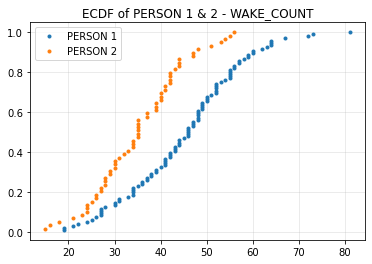

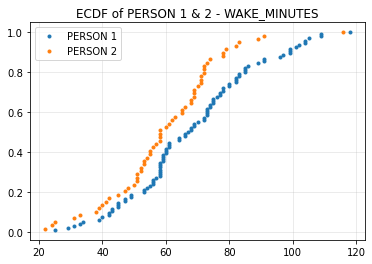

In [19]:
cols = [x for x in PERSON1.df_sleep_durations.columns if 'time' not in x.lower()]

for col in cols:
    # PERSON 1:
    plt.figure()
    x,y = ecdf(PERSON1.df_sleep_durations[col])
    plt.plot(x,y,'.',label='PERSON 1')

    # PERSON 2:
    x,y = ecdf(PERSON2.df_sleep_durations[col])
    plt.plot(x,y,'.',label='PERSON 2')

    plt.title('ECDF of PERSON 1 & 2 - ' + col.upper())
    plt.grid(':',alpha=0.3)
    plt.legend()
plt.show()

### HRV - Full Day:

In [20]:
PERSON1.df_hrv_stats_full_day.columns

Index(['Max_PP_interval', 'Min_PP_interval', 'SD_PP_interval',
       'Mean_PP_interval', 'PP_interval_range', 'SD_PP_5min', 'RMS_PP_diff',
       'Max_PP_1st_dydt', 'SD_PP_1st_dydt', 'Max_PP_2nd_dydt',
       'SD_PP_2nd_dydt'],
      dtype='object')

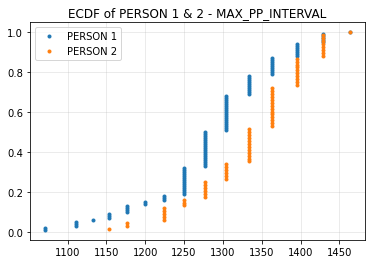

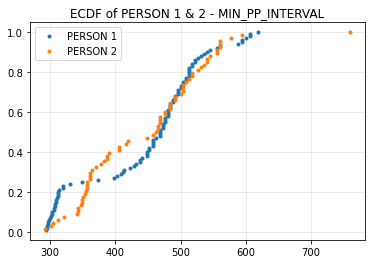

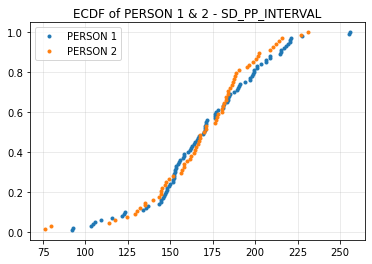

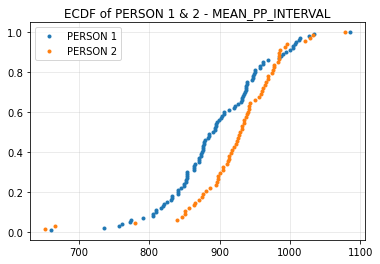

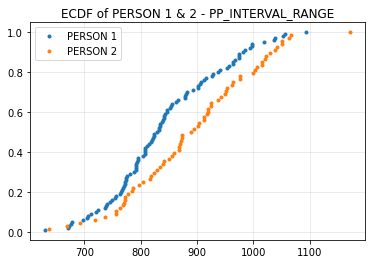

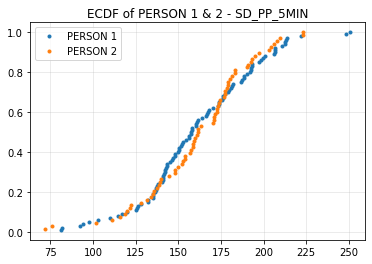

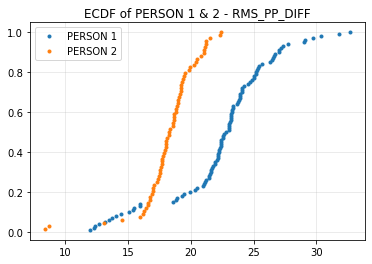

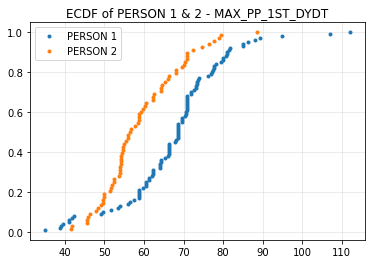

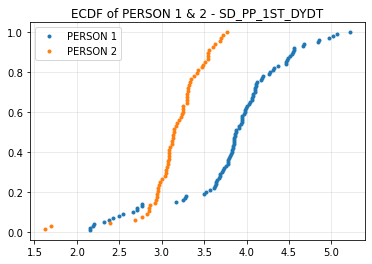

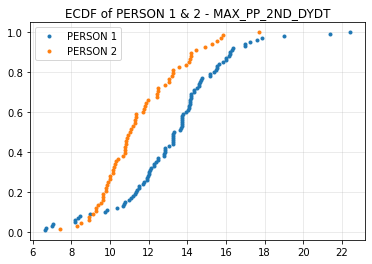

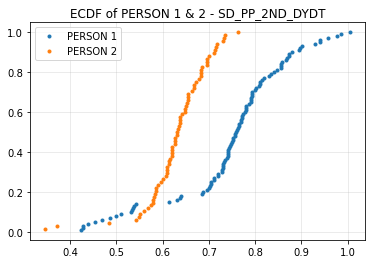

In [21]:
for col in PERSON1.df_hrv_stats_full_day.columns:
    # PERSON 1:
    plt.figure()
    x,y = ecdf(PERSON1.df_hrv_stats_full_day[col])
    plt.plot(x,y,'.',label='PERSON 1')

    # PERSON 2:
    x,y = ecdf(PERSON2.df_hrv_stats_full_day[col])
    plt.plot(x,y,'.',label='PERSON 2')

    plt.title('ECDF of PERSON 1 & 2 - ' + col.upper())
    plt.grid(':',alpha=0.3)
    plt.legend()
plt.show()

In the comparisons above, there are a few observable differences between person 1 and person 2. RHR, HRV in terms of the range of Pulse to pulse intervals, Root mean square of PP difference, and the maximum rate of change of PP interval. The mean PP interval and sleep efficiency were also higher in Person 2 than in person 1. The higher the PP interval translate to a lower Heart Rate, and shown in previous studies to be healthier.

There are very minute differences in indicators like the SDNN (calculated as Standard Deviation of the PP interval) in 5 seconds and in 5 minutes groupings.

Sleep.

Comparing with sleep data, there is little difference in the total sleep duration and minutes asleep of Person 1 and Person 2. PERSON 2 had longer durations of deep sleep and lesser wake times as compared to PERSON 1, showing more restlessness during sleep. This explains the sleep efficiency being lower for PERSON 1. The Rapid Eye Movement (REM) sleep counts was higher for PERSON 1 but the REM sleep duration turns out to be similar between the two of them. Dreams are related to REM sleep, thus, Person 2 might be having longer dreams.

HRV.

The Root Mean Square Difference, and the maximum rate of change (first derivative and second derivative) in sucessive PP intervals are all lower in PERSON 2 than in PERSON 1. The Rate of change in PP interval also varies lesser in PERSON 2 (lower in SD). This shows that Person1's heart is working harder than Person2's and could be an indication of Person 2 being healthier than Person 1 due to obesity.

However, this result might also be due to amount of activity from each person. The number of steps taken by Person1 was more than Person 2. The calories output by PERSON1 was also more then PERSON2. One thing is for sure, PERSON1 is working harder than PERSON2.

RHR is lower for Person2 than in Person1. This points to Person2 being healthier than Person2.

There was a difference in the BMI of person 1 and 2 at the time data was taken. Person 2 BMI is within the normal range whereas person 1 BMI was in the overweight range. This observation conincides with past studies describing the correlation of BMI and sleep and heart rate.

#### Proves that observations are correct using existing studies on a surface level.

### Comparison using Boot Strap Mean and Median Values for confirmation

### RHR

In [29]:

print("After 10,000 bootstrap sample replication:")

for i, subject in enumerate(PERSON_LIST): # applying the same steps for Person 1 and 2.
    
    bs_RHR_mean = draw_bs_reps(subject.df_resting_hr.restingHeartRate,np.mean,10000)
    bs_RHR_mean, bs_RHR_mean_sd = bs_RHR_mean.mean(),bs_RHR_mean.std()

    bs_RHR_median = draw_bs_reps(subject.df_resting_hr.restingHeartRate,np.median,10000)
    bs_RHR_median, bs_RHR_median_sd = bs_RHR_median.mean(),bs_RHR_median.std()

    print("\nPERSON {}:".format(i+1))
    print(" Mean RHR: {} -+ {}".format(bs_RHR_mean, bs_RHR_mean_sd))
    print(" Median RHR: {} -+ {}".format(bs_RHR_median, bs_RHR_median_sd))

After 10,000 bootstrap sample replication:

PERSON 1:
 Mean RHR: 59.14669609375 -+ 0.16527620547456107
 Median RHR: 59.0028 -+ 0.05866992415198779

PERSON 2:
 Mean RHR: 56.59598405797102 -+ 0.17543368747151428
 Median RHR: 56.723 -+ 0.4475164801434692


### Sleep Data

In [161]:
# Perform Bootstrap and put into Dataframe:

dict_mean = {}
dict_median = {}

list_mean = []
list_median = []

cols = [x for x in PERSON1.df_sleep_durations.columns if 'time' not in x.lower()]

for i, subject in enumerate(PERSON_LIST): # applying the same steps for Person 1 and 2.

    dict_mean['subject'] = i+1

    for x in cols:
        bs_mean = draw_bs_reps(subject.df_sleep_durations[x],np.mean,10000)
        bs_mean, bs_mean_sd = bs_mean.mean(),bs_mean.std()

        bs_median = draw_bs_reps(subject.df_sleep_durations[x],np.median,10000)
        bs_median, bs_median_sd = bs_median.mean(),bs_median.std()

        dict_mean[x+"_mean"] = bs_mean
        dict_mean[x+"_mean_sd"] = bs_mean_sd
        dict_median[x+"_median"] = bs_median
        dict_median[x+"_median_sd"] = bs_median_sd

    list_mean.append(dict_mean.copy())
    list_median.append(dict_median.copy())

pd_sleep_compare_mean, pd_sleep_compare_median = pd.DataFrame(list_mean), pd.DataFrame(list_median)



In [162]:
print("After 10,000 bootstrap sample replication: (Value -+SD)")

pd_sleep_compare_mean


After 10,000 bootstrap sample replication: (Value -+SD)


,subject,duration_mean,duration_mean_sd,minutesAsleep_mean,minutesAsleep_mean_sd,efficiency_mean,efficiency_mean_sd,DeepSleep_Count_mean,DeepSleep_Count_mean_sd,DeepSleep_Minutes_mean,...,LightSleep_Minutes_mean,LightSleep_Minutes_mean_sd,RemSleep_Count_mean,RemSleep_Count_mean_sd,RemSleep_Minutes_mean,RemSleep_Minutes_mean_sd,Wake_Count_mean,Wake_Count_mean_sd,Wake_Minutes_mean,Wake_Minutes_mean_sd
0,1,464.067286,10.697276,395.779221,9.191388,90.012186,0.271977,4.346360,0.156028,70.460825,...,243.251455,5.778198,14.816098,0.623018,82.033980,2.986641,45.154946,1.281577,68.388131,2.062596
1,2,475.589263,13.277118,416.145664,11.548292,95.779085,0.272124,4.424398,0.188177,79.623917,...,248.721400,6.934194,10.904273,0.550544,87.756995,4.087944,35.302234,1.267171,59.726959,2.224403


In [163]:
pd_sleep_compare_median

,duration_median,duration_median_sd,minutesAsleep_median,minutesAsleep_median_sd,efficiency_median,efficiency_median_sd,DeepSleep_Count_median,DeepSleep_Count_median_sd,DeepSleep_Minutes_median,DeepSleep_Minutes_median_sd,...,LightSleep_Minutes_median,LightSleep_Minutes_median_sd,RemSleep_Count_median,RemSleep_Count_median_sd,RemSleep_Minutes_median,RemSleep_Minutes_median_sd,Wake_Count_median,Wake_Count_median_sd,Wake_Minutes_median,Wake_Minutes_median_sd
0,462.6826,15.499355,395.8648,12.166617,90.06165,0.288919,4.03085,0.164843,71.27925,3.247821,...,241.14395,6.729417,14.6659,0.812667,85.5850,3.650421,45.9365,1.509526,67.0312,3.622572
1,480.8804,16.777392,422.6379,11.002817,96.14330,0.451846,4.07310,0.260301,81.76670,2.822423,...,246.84680,7.630592,10.9455,0.570026,84.9827,5.586681,35.1019,1.672159,59.5912,3.166083


In [164]:
pd_sleep_compare_mean.corr()['subject']

subject                       1.0
duration_mean                 1.0
duration_mean_sd              1.0
minutesAsleep_mean            1.0
minutesAsleep_mean_sd         1.0
efficiency_mean               1.0
efficiency_mean_sd            1.0
DeepSleep_Count_mean          1.0
DeepSleep_Count_mean_sd       1.0
DeepSleep_Minutes_mean        1.0
DeepSleep_Minutes_mean_sd     1.0
LightSleep_Count_mean        -1.0
LightSleep_Count_mean_sd      1.0
LightSleep_Minutes_mean       1.0
LightSleep_Minutes_mean_sd    1.0
RemSleep_Count_mean          -1.0
RemSleep_Count_mean_sd       -1.0
RemSleep_Minutes_mean         1.0
RemSleep_Minutes_mean_sd      1.0
Wake_Count_mean              -1.0
Wake_Count_mean_sd           -1.0
Wake_Minutes_mean            -1.0
Wake_Minutes_mean_sd          1.0
Name: subject, dtype: float64

In [165]:
print("Percentage Difference of Person2 from Person1:\n")
pd_x = pd_sleep_compare_mean.pct_change()
for x in [x for x in pd_x.columns if 'subject' not in x and 'sd' not in x]:
    print("{:<30}:\t {:>7.3f} %".format(x,pd_x[x].iloc[1]*100))

Percentage Difference of Person2 from Person1:

duration_mean                 :	   2.483 %
minutesAsleep_mean            :	   5.146 %
efficiency_mean               :	   6.407 %
DeepSleep_Count_mean          :	   1.795 %
DeepSleep_Minutes_mean        :	  13.005 %
LightSleep_Count_mean         :	 -12.803 %
LightSleep_Minutes_mean       :	   2.249 %
RemSleep_Count_mean           :	 -26.403 %
RemSleep_Minutes_mean         :	   6.976 %
Wake_Count_mean               :	 -21.820 %
Wake_Minutes_mean             :	 -12.665 %


Positive correlation '1' means PERSON 2 had a higher value, while Negative value means PERSON 1 had a higher value. Through the number of positive correlation, PERSON 2's sleep quality was better than PERSON 1.

### Comparison of Sleep times

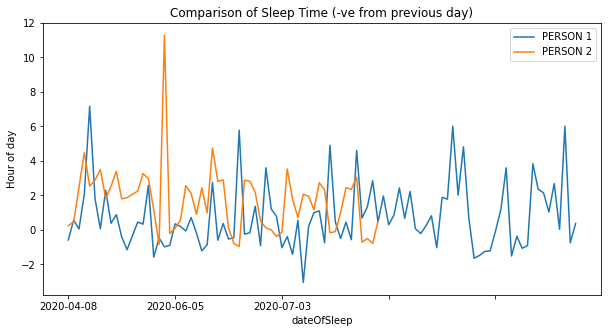

In [17]:
plt.figure(figsize=(10,5))

for i, subject in enumerate(PERSON_LIST): # applying the same steps for Person 1 and 2.

    # Check if Start Time is on the same day of DateOfSleep:
    check = subject.df_sleep_durations.startTime >= pd.DatetimeIndex(subject.df_sleep_durations.index)

    # minus 24h if start time is not the DateOfSleep:
    hour_of_sleep = subject.df_sleep_durations[~check].startTime.dt.hour - 24.0
    hour_of_sleep = pd.concat([hour_of_sleep,subject.df_sleep_durations[check].startTime.dt.hour])

    time_of_sleep = hour_of_sleep.sort_index() + subject.df_sleep_durations.startTime.sort_index().dt.minute / 60.0

    time_of_sleep.plot(label="PERSON "+str(i+1))
    plt.title("Comparison of Sleep Time (-ve from previous day)")
    plt.ylabel("Hour of day")
    plt.legend()

plt.show()

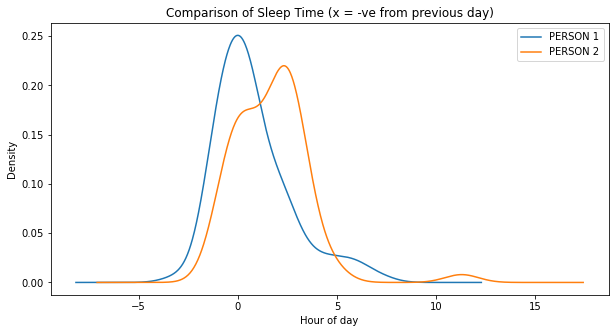

In [21]:
plt.figure(figsize=(10,5))

for i, subject in enumerate(PERSON_LIST): # applying the same steps for Person 1 and 2.

    # Check if Start Time is on the same day of DateOfSleep:
    check = subject.df_sleep_durations.startTime >= pd.DatetimeIndex(subject.df_sleep_durations.index)

    # minus 24h if start time is not the DateOfSleep:
    hour_of_sleep = subject.df_sleep_durations[~check].startTime.dt.hour - 24.0
    hour_of_sleep = pd.concat([hour_of_sleep,subject.df_sleep_durations[check].startTime.dt.hour])

    time_of_sleep = hour_of_sleep.sort_index() + subject.df_sleep_durations.startTime.sort_index().dt.minute / 60.0

    time_of_sleep.plot(kind='kde',label="PERSON "+str(i+1))
    plt.title("Comparison of Sleep Time (x = -ve from previous day)")
    plt.xlabel("Hour of day")
    plt.legend()

plt.show()

From the above plot, the sleep timings for both person are both around or past midnight. PERSON2 had slept later than PERSON1, looking at the peak of the KDE plots.

### HRV Data

In [166]:
# Perform Bootstrap and put into Dataframe:

dict_mean = {}
dict_median = {}

list_mean = []
list_median = []

cols = [x for x in PERSON1.df_hrv_stats_full_day.columns]

for i, subject in enumerate(PERSON_LIST): # applying the same steps for Person 1 and 2.

    dict_mean['subject'] = i+1

    for x in cols:
        bs_mean = draw_bs_reps(subject.df_hrv_stats_full_day[x],np.mean,10000)
        bs_mean, bs_mean_sd = bs_mean.mean(),bs_mean.std()

        bs_median = draw_bs_reps(subject.df_hrv_stats_full_day[x],np.median,10000)
        bs_median, bs_median_sd = bs_median.mean(),bs_median.std()

        dict_mean[x+"_mean"] = bs_mean
        dict_mean[x+"_mean_sd"] = bs_mean_sd
        dict_median[x+"_median"] = bs_median
        dict_median[x+"_median_sd"] = bs_median_sd

    list_mean.append(dict_mean.copy())
    list_median.append(dict_median.copy())

pd_hrv_compare_mean, pd_hrv_compare_median = pd.DataFrame(list_mean), pd.DataFrame(list_median)



In [167]:
print("Percentage Difference of Person2 from Person1:\n")
pd_x = pd_hrv_compare_mean.pct_change()
for x in [x for x in pd_x.columns if 'subject' not in x and 'sd' not in x]:
    print("{:<30}:\t {:>7.3f} %".format(x,pd_x[x].iloc[1]*100))

Percentage Difference of Person2 from Person1:

Max_PP_interval_mean          :	   3.690 %
Min_PP_interval_mean          :	   0.018 %
SD_PP_interval_mean           :	  -1.244 %
Mean_PP_interval_mean         :	   3.127 %
PP_interval_range_mean        :	   5.654 %
SD_PP_5min_mean               :	   0.042 %
RMS_PP_diff_mean              :	 -18.588 %
Max_PP_1st_dydt_mean          :	 -12.687 %
SD_PP_1st_dydt_mean           :	 -17.425 %
Max_PP_2nd_dydt_mean          :	 -13.138 %
SD_PP_2nd_dydt_mean           :	 -15.469 %


The Root Mean Square Difference, and the maximum rate of change (first derivative and second derivative) in sucessive PP intervals are all lower in PERSON 2 than in PERSON 1. The Rate of change in PP interval also varies lesser in PERSON 2 (lower in SD). This shows that Person1's heart is working harder than Person2's and could be an indication of Person 2 being healthier than Person 1 due to obesity.